In [279]:
%matplotlib notebook
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits
from ipywidgets import widgets
beam_file= '/home/mkolopanis/src/PRISim/prisim/data/beams/HERA_HFSS_X4Y2H_4900.hmap'

We need to make a weighting function which will grid our **arbitrarily** placed Antenna UVW values onto the gridded UV plane

Consider a simple 1-d example with the HERA HFSS beam slice as the convolution kernel

In [3]:
beam_x = fits.getdata(beam_file,'BEAM_X')
beam_freqs = fits.getdata(beam_file,'FREQS_X')
ind = np.argmin(np.abs(beam_freqs*1e-6 - 150))
beam_150 = beam_x.T[ind]

<IPython.core.display.Javascript object>


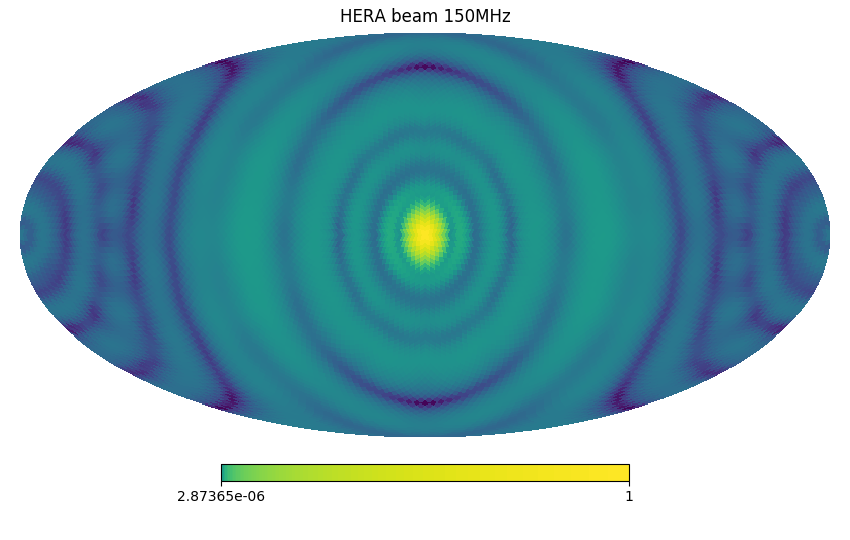

In [4]:
hp.mollview(beam_150, rot=[0,90,0], title="HERA beam 150MHz", norm='log')

In [51]:
def hpx_to_ortho(map, xsize=None, oversample=True):
    """Create Othrographic projection of a healpix map.
    
    Assumes theta=0 is the peak of Beam, Rotates to theta=90deg before projection."""
    nside = hp.get_nside(map)
    if xsize is None:
        pix_size = np.sqrt(hp.nside2pixarea(nside))
        if oversample:
            pix_size/5.
        xsize = int(np.ceil(np.pi/pix_size))
    R = hp.projector.OrthographicProj(xsize=xsize, half_sky=True, rot=[0,90.,0])
    f = lambda x,y,z: hp.pixelfunc.vec2pix(nside, x,y,z)
    masked_beam = np.ma.masked_invalid(R.projmap(map, f))
    masked_beam.fill_value = np.NAN
    return masked_beam

<IPython.core.display.Javascript object>


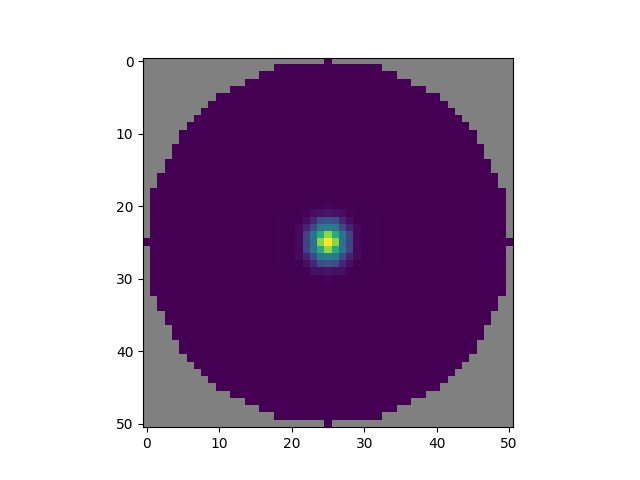

In [351]:
xsize=51
cen = (xsize -1)/2 
beam_ortho = hpx_to_ortho(beam_150, xsize=xsize)
beam_1d = beam_ortho[cen]
plt.figure()
plt.imshow(beam_ortho)

<IPython.core.display.Javascript object>


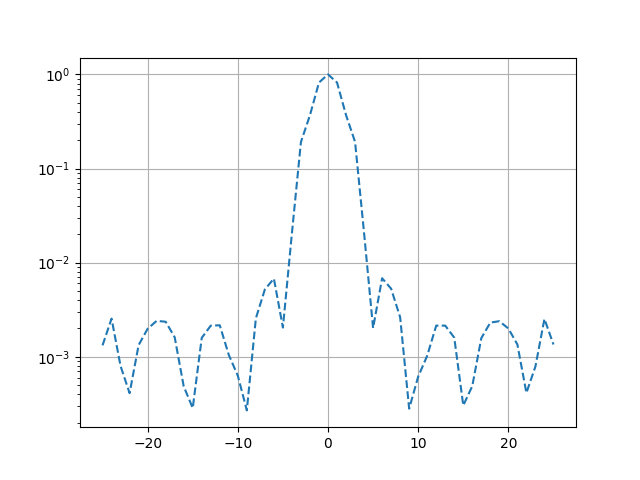

In [352]:
plt.figure()
plt.yscale('log')
plt.grid()
plt.plot(np.arange(xsize)-cen, beam_ortho[cen].T, '--')

In [353]:
beam_fft = np.ma.masked_invalid(beam_ortho).filled(0)
beam_uv = np.fft.fftshift(np.fft.fft2(beam_fft), axes=[1,0])

<IPython.core.display.Javascript object>


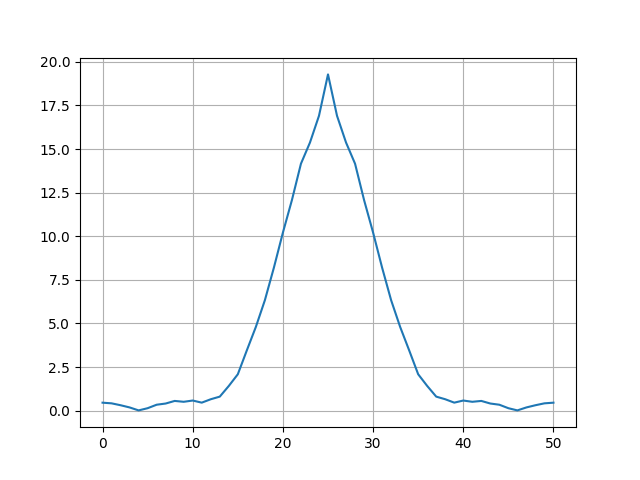

In [354]:
plt.figure()
plt.grid()
plt.plot(np.abs(beam_uv[cen]))

In [380]:
def grid_weights(uv, grid):
    """Compute Weight function for arbitrary baseline vector uv on a grid.
    
    Assumes uv is in pixels."""
    if grid is None:
        return 0
    weights = 1. - np.abs(uv - grid)/np.diff(grid)[0]
#     weights = 1. - (np.abs(uv - grid)/np.diff(grid)[0])**2
#     weights = np.exp( - (uv - grid)**2/(2*np.diff(grid)[0]**2))
#     weights = np.exp( - abs(uv - grid)/(np.diff(grid)[0]))
    weights = np.ma.masked_less_equal(weights, 1e-1).filled(0)
    #     x,y = np.meshgrid( np.arange(grid_size), np.range(grid_size))
    #     correct so pixels are zero at the center
    #     y -= (grid_size - 1) /2    
    #     weights = 1 - np.abs(uv - np.linalg.norm([x,y], axis=0))
    return weights

<IPython.core.display.Javascript object>


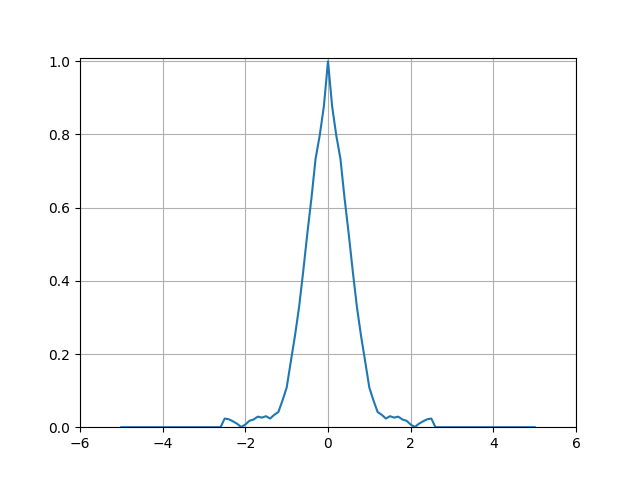

<function __main__.plot_weights>

In [381]:
plt.figure()
plt.ylim([0,1])
plt.xlim([-5,5])
def plot_weights(x):
    plt.clf()
    plt.ylim([None,1.01])
    plt.xlim([-6,6])
#     plt.yscale('symlog', linthreshy=1e-2)
    plt.grid(which='both')
    grid = np.linspace(-5,5,101)
    weights = grid_weights(x, grid)
    uv = np.convolve(weights, np.abs(beam_uv[cen])/np.abs(beam_uv[cen]).sum(), mode='same')
    uv /= uv.max()
#     plt.plot(grid, weights, 'k--')
    plt.plot(grid, uv)
    plt.show()
x_slide = widgets.FloatSlider(min=-5,max=5,step=.01,value=0,continuous_update=True)  
widgets.interact(plot_weights,x=x_slide)

In [254]:
from matplotlib import rc, animation
rc('animation', html='html5')

<IPython.core.display.Javascript object>


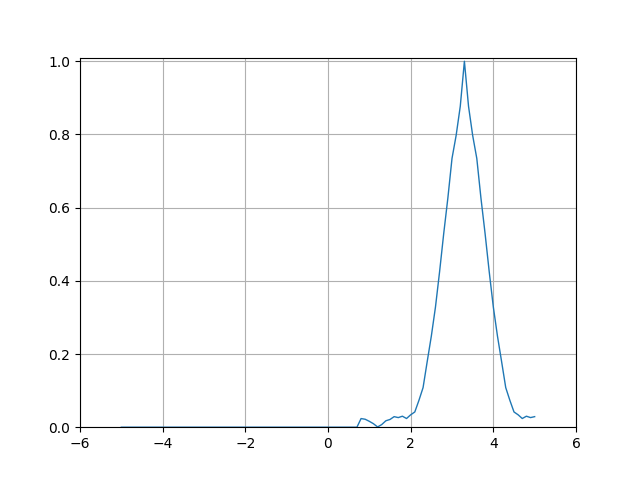

In [337]:
fig, ax = plt.subplots()

ax.set_xlim(( -6, 6))
ax.set_ylim((None, 1.01))
ax.grid(which='both')
line, = ax.plot([], [], lw=1)

def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    grid = np.linspace(-5,5,101)
    x = np.concatenate([grid, grid[::-1]])
    weights = grid_weights(x[i], grid)
    uv = np.convolve(weights, np.abs(beam_uv[cen])/np.abs(beam_uv[cen]).sum(), mode='same')
    uv /= uv.max()
    line.set_data(grid, uv)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)
anim